In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =6.375563e-24

nband = 80

ng =9

ng_adju = (/ 0 , 0 /) 

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.65 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

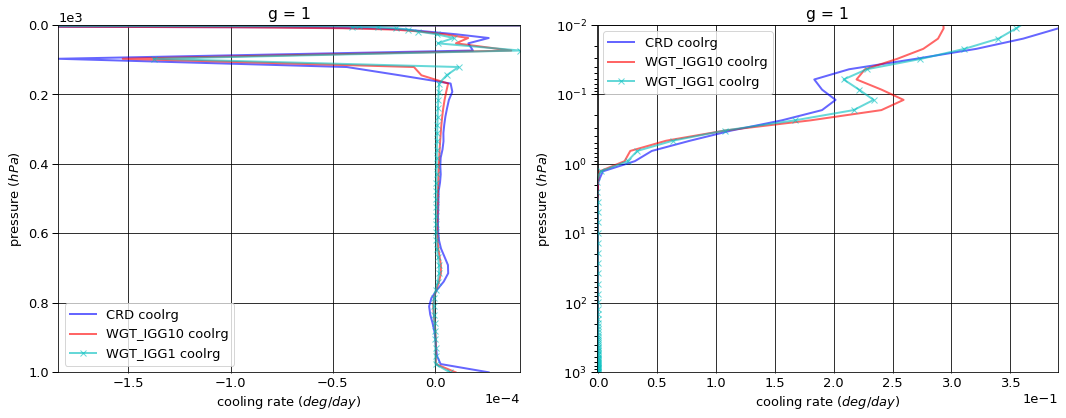

# Figure: cooling rate g-group 2

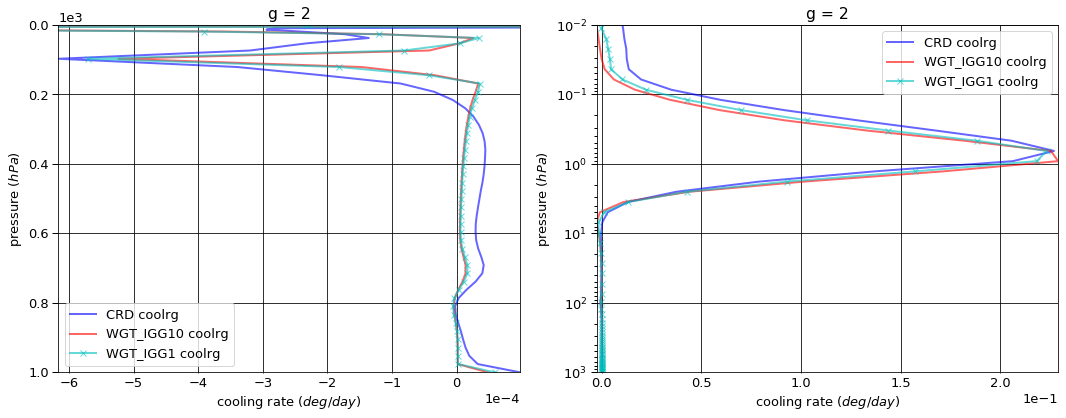

# Figure: cooling rate g-group 3

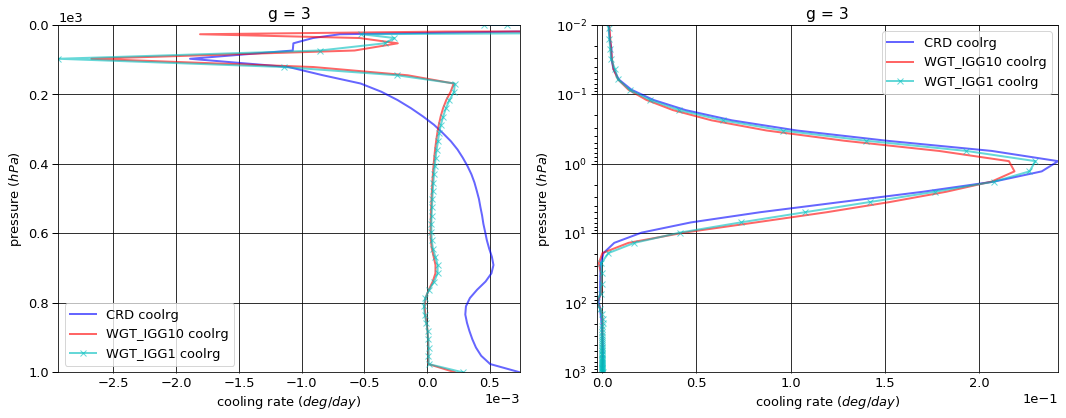

# Figure: cooling rate g-group 4

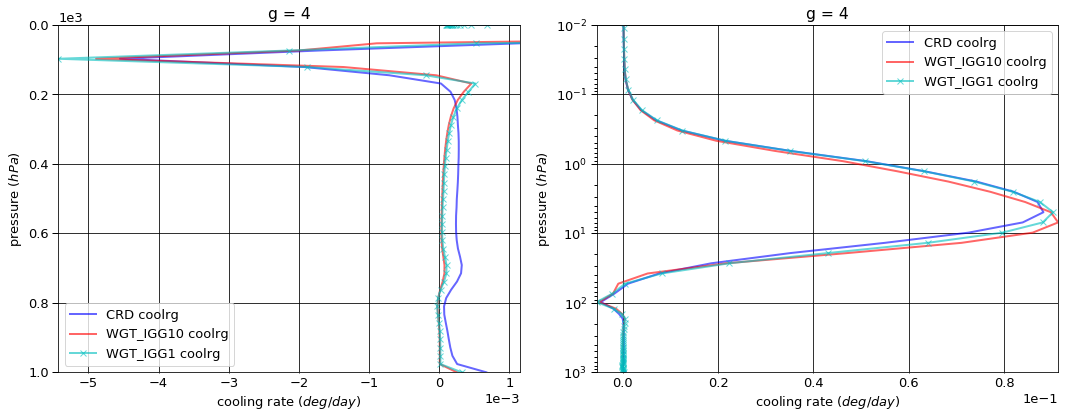

# Figure: cooling rate g-group 5

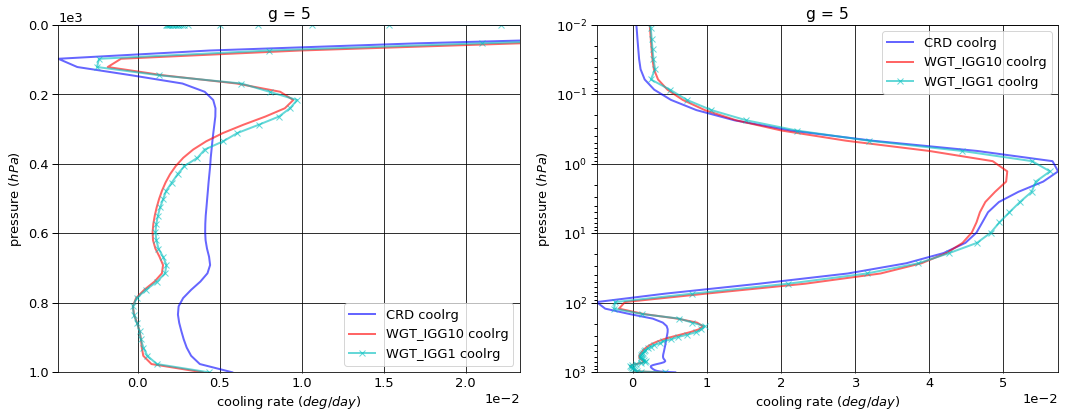

# Figure: cooling rate g-group 6

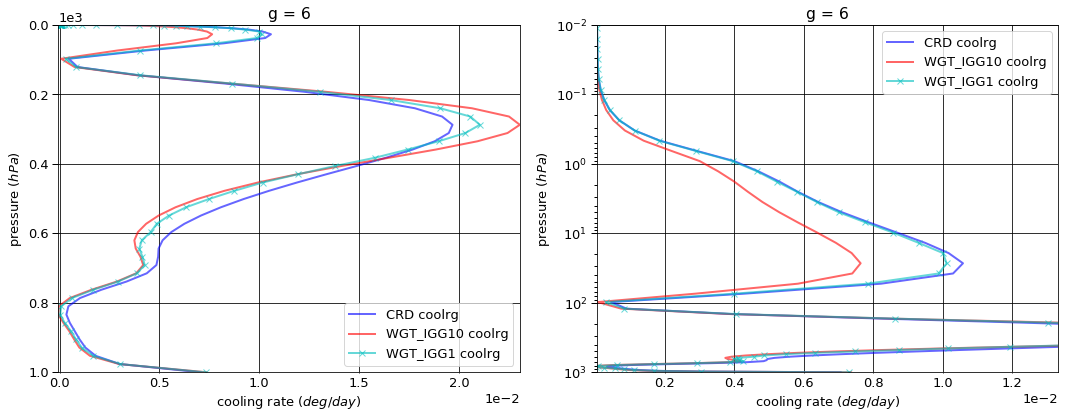

# Figure: cooling rate g-group 7

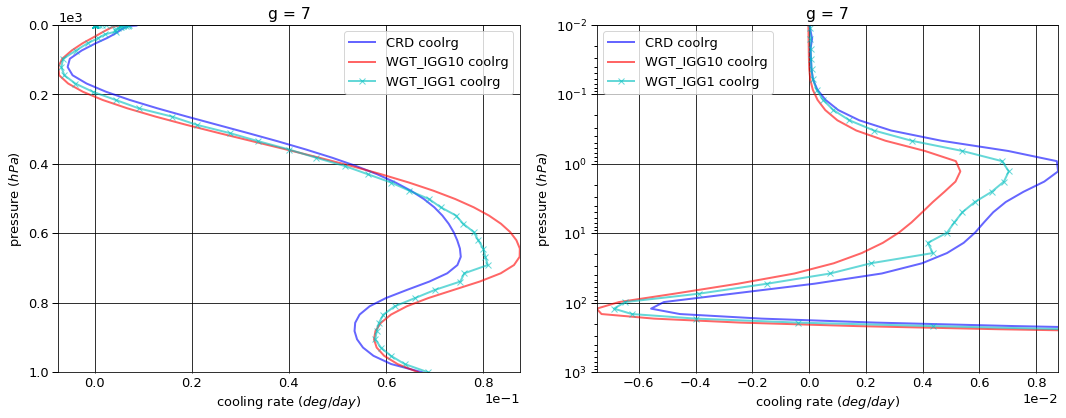

# Figure: cooling rate g-group 8

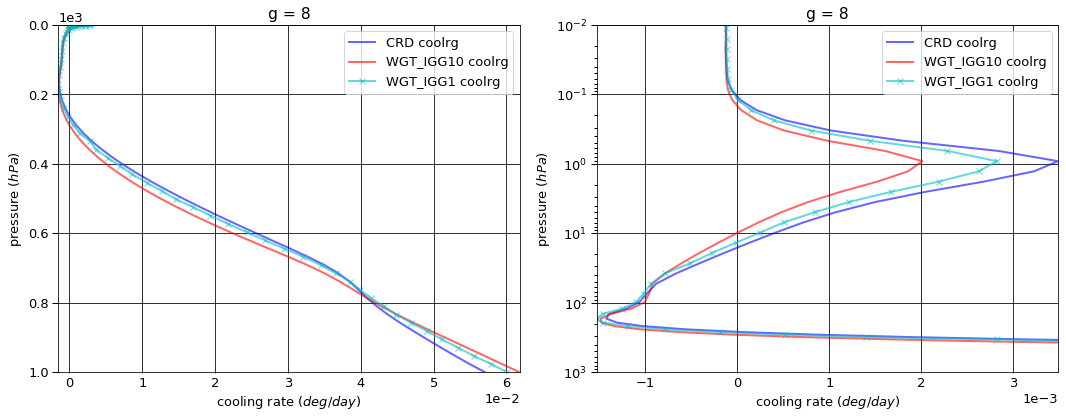

# Figure: cooling rate g-group 9

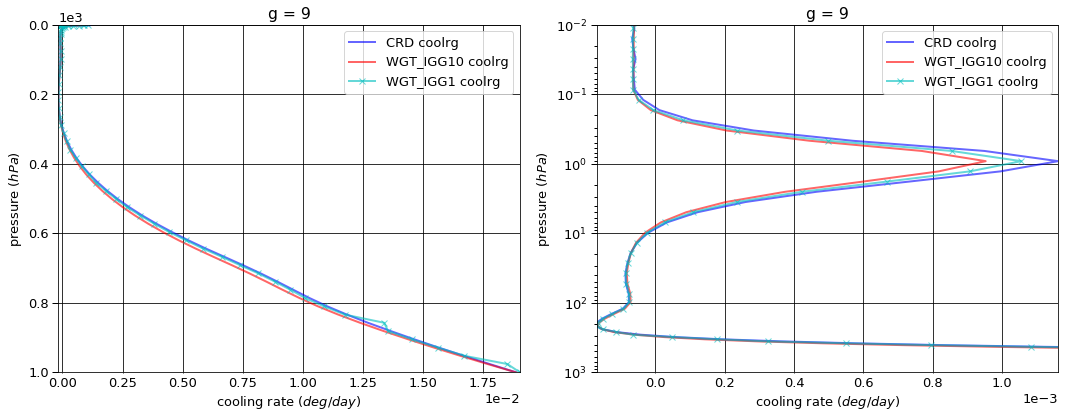

# Figure: cooling rate g-group total

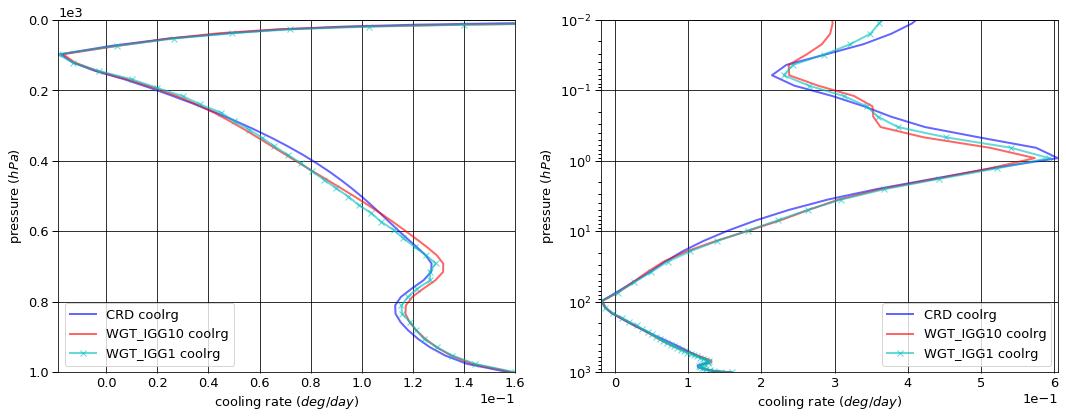

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011756  0.000000  -0.011756
  1013.0   76     -0.028390  0.028309  -0.000081
2 0.0      1      -0.037954  0.000000  -0.037954
  1013.0   76     -0.063043  0.062576  -0.000467
3 0.0      1      -0.148239  0.000000  -0.148239
  1013.0   76     -0.275821  0.262374  -0.013447
4 0.0      1      -0.195501  0.000000  -0.195501
  1013.0   76     -0.476412  0.471388  -0.005024
5 0.0      1      -0.760130  0.000000  -0.760130
  1013.0   76     -1.822301  1.688490  -0.133811
6 0.0      1      -0.967997  0.000000  -0.967997
  1013.0   76     -2.493990  2.460883  -0.033107
7 0.0      1      -6.722966  0.000000  -6.722966
  1013.0   76    -10.342605  8.949286  -1.393319
8 0.0      1      -7.957432  0.000000  -7.957432
  1013.0   76     -8.780112  3.290527  -5.489585
9 0.0      1     -14.072455  0.000000 -14.072455
  1013.0   76    -14.209061  0.748448 -13.460613


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011262  0.000000  -0.011262
  1013.0   76     -0.028390  0.028362  -0.000028
2 0.0      1      -0.039421  0.000000  -0.039421
  1013.0   76     -0.063043  0.062909  -0.000134
3 0.0      1      -0.144322  0.000000  -0.144322
  1013.0   76     -0.275821  0.275201  -0.000620
4 0.0      1      -0.196683  0.000000  -0.196683
  1013.0   76     -0.476412  0.475713  -0.000699
5 0.0      1      -0.545996  0.000000  -0.545996
  1013.0   76     -1.822301  1.809223  -0.013078
6 0.0      1      -0.925974  0.000000  -0.925974
  1013.0   76     -2.493990  2.463150  -0.030840
7 0.0      1      -6.667189  0.000000  -6.667189
  1013.0   76    -10.342605  9.308833  -1.033772
8 0.0      1      -8.053317  0.000000  -8.053317
  1013.0   76     -8.780112  3.123682  -5.656430
9 0.0      1     -14.082777  0.000000 -14.082777
  1013.0   76    -14.209061  0.715515 -13.493546


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011310  0.000000  -0.011310
  1013.0   76     -0.028390  0.028370  -0.000020
2 0.0      1      -0.038903  0.000000  -0.038903
  1013.0   76     -0.063043  0.062878  -0.000164
3 0.0      1      -0.143231  0.000000  -0.143231
  1013.0   76     -0.275821  0.275026  -0.000795
4 0.0      1      -0.194880  0.000000  -0.194880
  1013.0   76     -0.476412  0.475527  -0.000884
5 0.0      1      -0.564289  0.000000  -0.564289
  1013.0   76     -1.822301  1.806645  -0.015656
6 0.0      1      -0.925982  0.000000  -0.925982
  1013.0   76     -2.493990  2.461670  -0.032321
7 0.0      1      -6.691888  0.000000  -6.691888
  1013.0   76    -10.342605  9.094399  -1.248205
8 0.0      1      -7.977649  0.000000  -7.977649
  1013.0   76     -8.780112  3.280247  -5.499865
9 0.0      1     -14.076164  0.000000 -14.076164
  1013.0   76    -14.209061  0.743111 -13.465950


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000494  0.000000  0.000494
  1013.0   76     0.000000  0.000054  0.000054
2 0.0      1     -0.001467  0.000000 -0.001467
  1013.0   76     0.000000  0.000333  0.000333
3 0.0      1      0.003917  0.000000  0.003917
  1013.0   76     0.000000  0.012827  0.012827
4 0.0      1     -0.001182  0.000000 -0.001182
  1013.0   76     0.000000  0.004325  0.004325
5 0.0      1      0.214133  0.000000  0.214133
  1013.0   76     0.000000  0.120733  0.120733
6 0.0      1      0.042023  0.000000  0.042023
  1013.0   76     0.000000  0.002267  0.002267
7 0.0      1      0.055777  0.000000  0.055777
  1013.0   76     0.000000  0.359547  0.359547
8 0.0      1     -0.095885  0.000000 -0.095885
  1013.0   76     0.000000 -0.166845 -0.166845
9 0.0      1     -0.010322  0.000000 -0.010322
  1013.0   76     0.000000 -0.032933 -0.032933


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000446  0.000000  0.000446
  1013.0   76     0.000000  0.000061  0.000061
2 0.0      1     -0.000949  0.000000 -0.000949
  1013.0   76     0.000000  0.000303  0.000303
3 0.0      1      0.005008  0.000000  0.005008
  1013.0   76     0.000000  0.012651  0.012651
4 0.0      1      0.000620  0.000000  0.000620
  1013.0   76     0.000000  0.004139  0.004139
5 0.0      1      0.195840  0.000000  0.195840
  1013.0   76     0.000000  0.118155  0.118155
6 0.0      1      0.042014  0.000000  0.042014
  1013.0   76     0.000000  0.000787  0.000787
7 0.0      1      0.031078  0.000000  0.031078
  1013.0   76     0.000000  0.145114  0.145113
8 0.0      1     -0.020217  0.000000 -0.020217
  1013.0   76     0.000000 -0.010280 -0.010280
9 0.0      1     -0.003709  0.000000 -0.003709
  1013.0   76     0.000000 -0.005337 -0.005337

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.392252
  1001.112500 75     0.000026
2 0.000312    1      0.001310
  1001.112500 75     0.000098
3 0.000312    1      0.000452
  1001.112500 75     0.000739
4 0.000312    1      0.000084
  1001.112500 75     0.000673
5 0.000312    1     -0.000050
  1001.112500 75     0.005764
6 0.000312    1      0.000031
  1001.112500 75     0.007065
7 0.000312    1     -0.000074
  1001.112500 75     0.067492
8 0.000312    1     -0.000132
  1001.112500 75     0.057067
9 0.000312    1     -0.000056
  1001.112500 75     0.018850


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.225436
  1001.112500 75     0.000010
2 0.000312    1     -0.008058
  1001.112500 75     0.000048
3 0.000312    1      0.001232
  1001.112500 75     0.000223
4 0.000312    1      0.000110
  1001.112500 75     0.000252
5 0.000312    1      0.001669
  1001.112500 75     0.003953
6 0.000312    1      0.000024
  1001.112500 75     0.007366
7 0.000312    1     -0.000059
  1001.112500 75     0.066685
8 0.000312    1     -0.000123
  1001.112500 75     0.061831
9 0.000312    1     -0.000056
  1001.112500 75     0.018844


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.321413
  1001.112500 75     0.000007
2 0.000312    1     -0.005820
  1001.112500 75     0.000059
3 0.000312    1      0.000452
  1001.112500 75     0.000283
4 0.000312    1      0.000100
  1001.112500 75     0.000322
5 0.000312    1      0.001714
  1001.112500 75     0.004322
6 0.000312    1      0.000035
  1001.112500 75     0.007317
7 0.000312    1     -0.000013
  1001.112500 75     0.068693
8 0.000312    1     -0.000123
  1001.112500 75     0.060108
9 0.000312    1     -0.000058
  1001.112500 75     0.019011


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.668156e-01
  1001.112500 75    -1.614045e-05
2 0.000312    1     -9.368164e-03
  1001.112500 75    -4.975143e-05
3 0.000312    1      7.801849e-04
  1001.112500 75    -5.158646e-04
4 0.000312    1      2.650553e-05
  1001.112500 75    -4.212555e-04
5 0.000312    1      1.719462e-03
  1001.112500 75    -1.810891e-03
6 0.000312    1     -6.623549e-06
  1001.112500 75     3.002215e-04
7 0.000312    1      1.484033e-05
  1001.112500 75    -8.070090e-04
8 0.000312    1      9.015830e-06
  1001.112500 75     4.763908e-03
9 0.000312    1      1.701310e-07
  1001.112500 75    -6.740000e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -7.083845e-02
  1001.112500 75    -1.897473e-05
2 0.000312    1     -7.130306e-03
  1001.112500 75    -3.920757e-05
3 0.000312    1      2.453800e-07
  1001.112500 75    -4.553210e-04
4 0.000312    1      1.639073e-05
  1001.112500 75    -3.509609e-04
5 0.000312    1      1.763649e-03
  1001.112500 75    -1.442001e-03
6 0.000312    1      4.536179e-06
  1001.112500 75     2.519993e-04
7 0.000312    1      6.086425e-05
  1001.112500 75     1.201400e-03
8 0.000312    1      9.139160e-06
  1001.112500 75     3.040684e-03
9 0.000312    1     -1.978775e-06
  1001.112500 75     1.611540e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.874429,0.000000,-30.874429
1013.0,76,-38.491735,17.962281,-20.529454



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.666941,0.000000,-30.666941
1013.0,76,-38.491735,18.262588,-20.229147



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.624296,0.000000,-30.624296
1013.0,76,-38.491735,18.227874,-20.263861



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.207488,0.000000,0.207488
1013.0,76,0.000000,0.300307,0.300307



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.250133,0.000000,0.250133
1013.0,76,0.000000,0.265593,0.265593


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.393817
1001.112500,75,0.157775



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.220177
1001.112500,75,0.159211



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.317701
1001.112500,75,0.160124



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.173640
1001.112500,75,0.001436



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.076116
1001.112500,75,0.002349


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
